In [1]:

import readgadget as rg 
import matplotlib.gridspec as gridspec
from matplotlib import style
import numpy as np
import matplotlib.pyplot as plt
import imageio
from scipy.spatial import cKDTree
from joblib import Parallel, delayed
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import HTML
from scipy.stats import gaussian_kde

In [ ]:
def cent_h(X):

    
    # 构建 KD 树
    tree = cKDTree(X)  

    # 为每个点查询最近的30个邻居点
    dist, ind = tree.query(X, k=100)  

    # 计算局部密度
    epsilon = 1e-5
    rho = 1 / (dist + epsilon).sum(axis=1)

    # 密度最大值点的索引
    densest_idx = np.argmax(rho)

    return X[densest_idx]

def read(runpath ,i):
    snapfname = runpath + 'snapshot_' + str(i).zfill(3) 
    phalo = rg.readsnap(snapfname, 'pos', 'dm')
    idhalo = rg.readsnap(snapfname, 'pid', 'dm')
    pdisk = rg.readsnap(snapfname, 'pos', 'disk')
    pbulge = rg.readsnap(snapfname, 'pos', 'bulge')
    idisk = rg.readsnap(snapfname, 'pid', 'disk')
    ibulge = rg.readsnap(snapfname, 'pid', 'bulge')
    vbulge = rg.readsnap(snapfname, 'vel', 'bulge')
    
    '''pmw_halo = phalo[(idhalo > 0) & (idhalo <= 1000000)]
    pm31_halo = phalo[(idhalo > 1000000) & (idhalo <= 2500000)]
    pm33_halo = phalo[(idhalo > 2500000) & (idhalo <= 2750000)]
    
    pmw_disk = pdisk[(idisk > 2750000) & (idisk <= 3450000)]
    pmw_bulge = pbulge[(ibulge > 4650000) & (ibulge <= 4750000)]
    
    pm31_disk = pdisk[(idisk > 3450000) & (idisk <= 4650000)]    
    pm31_bulge = pbulge[(ibulge > 4750000) & (ibulge <= 4940000)]
    vm31_bulge = vbulge[(ibulge > 4940000) & (ibulge <= 4940000)]
    
    pm33_bulge = pbulge[(ibulge > 4940000) & (ibulge <= 5040000)]
    vm33_bulge = vbulge[(ibulge > 4940000) & (ibulge <= 5040000)]'''
    
    pmw_halo = phalo[(idhalo > 0) & (idhalo <= 1000000/2)]
    pm31_halo = phalo[(idhalo > 1000000/2) & (idhalo <= 2500000/2)]
    pm33_halo = phalo[(idhalo > 2500000/2) & (idhalo <= 2750000/2)]
    
    pmw_disk = pdisk[(idisk > 2750000/2) & (idisk <= 3450000/2)]
    pmw_bulge = pbulge[(ibulge > 4650000/2) & (ibulge <= 4750000/2)]
    
    pm31_disk = pdisk[(idisk > 3450000/2) & (idisk <= 4650000/2)]    
    pm31_bulge = pbulge[(ibulge > 4750000/2) & (ibulge <= 4940000/2)]
    vm31_bulge = vbulge[(ibulge > 4940000/2) & (ibulge <= 4940000/2)]
    
    pm33_bulge = pbulge[(ibulge > 4940000/2) & (ibulge <= 5040000/2)]
    vm33_bulge = vbulge[(ibulge > 4940000/2) & (ibulge <= 5040000/2)]
    
    cent_mw = cent_h(pmw_bulge)
    print(cent_mw)
    cent_m31 = cent_h(pm31_bulge)
    print(cent_m31)
    cent_m33 = cent_h(pm33_bulge)
    print(cent_m33)
    #pstar = pm31_bulge - cent_m31.reshape((1, 3))
    #rr2 = ((pstar**2).sum(-1))**0.5
    #vgal2 = np.mean(vm31_bulge[rr2 <= 5., :], axis=0)
    #print(vgal2)
    r_mw_m31= cent_m31-cent_mw
    r_mw_m33 = cent_m33-cent_mw
    r_m31_m33 = cent_m33-cent_m31
    posMW = np.r_[pmw_disk-cent_mw]    
    posM31 = np.r_[pm31_disk-cent_mw]
    posM33 = np.r_[pm33_halo-cent_mw]
    posdm_MW = np.r_[pmw_halo-cent_mw]
    posdm_M31 = np.r_[pm31_halo-cent_mw]
    return posMW, posM31,posM33,r_mw_m31,r_mw_m33,r_m31_m33


def create_density_map(pos, xlim, ylim, bins=100):
    H, xedges, yedges = np.histogram2d(pos[:, 0], pos[:, 1], bins=bins, range=[xlim, ylim])
    H = H.T  # Transpose to match the orientation of the plot
    return H, xedges, yedges

In [3]:
runpath = '/home/guozx/M31/Output/low_res/DR3_m33/'
i =00
posMW, posM31,posM33,r_mw_m31,r_mw_m33,r_m31_m33 = read(runpath,i)

Returning DM    Positions
Returning DM    Particle IDs
Returning DISK  Positions
Returning BULGE Positions
Returning DISK  Particle IDs
Returning BULGE Particle IDs
Returning BULGE Velocities
[0.00071697 0.00290847 0.00360545]
[-375.13318  605.5248  -278.83624]
[-515.3386  531.2821 -445.3489]


In [4]:
r0 = np.array([-375.1316149740847,605.5277209737903,-278.83597703631733]) 
v0 = np.array([37.53564320437491,-114.3816276001235,15.117831344570334])#dr3
x_COM = r0/np.linalg.norm(r0)
z_COM = -np.cross(r0,v0)/np.linalg.norm(np.cross(r0,v0))
y_COM = -np.cross(x_COM,z_COM)
print(x_COM,y_COM,z_COM)
#坐标变化的矩阵
A = np.array([x_COM,y_COM,z_COM])
A = A.T
frames = np.arange(0, 500, 5)
# 并行读取数据
results = Parallel(n_jobs=20)(delayed(read)(runpath, i) for i in frames)
rm31 = np.array([result[3] for result in results])
rm33 = np.array([result[4] for result in results])
rmw = np.zeros_like(rm31)
print(rm31[0],rm33[0],rmw[0])
COM = 1.5/(1+1.5+0.25)*rm31+0.25/(1+1.5+0.25)*rm33


rCOM_mw = np.dot(rmw-COM, A)
rCOM_m31 = np.dot(rm31-COM, A)
rCOM_m33 = np.dot(rm33-COM, A)
print(rCOM_mw[0],rCOM_m31[0],rCOM_m33[0])

[-0.49040497  0.79159899 -0.36451886] [0.46221467 0.59084539 0.66125587] [ 0.73882377  0.1557972  -0.65564218]


Returning DM    Positions
Returning DM    Positions
Returning DM    Particle IDs
Returning DM    Particle IDs
Returning DISK  Positions
Returning BULGE Positions
Returning DISK  Positions
Returning DISK  Particle IDs
Returning BULGE Particle IDs
Returning BULGE Positions
Returning BULGE Velocities
Returning DISK  Particle IDs
Returning DM    Positions
Returning BULGE Particle IDs
Returning BULGE Velocities
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Particle IDs
Returning DISK  Positions
Returning DM    Positions
Returning DM    Positions
Returning BULGE Positions
Returning DISK  Particle IDs
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Positions
Returning BULGE Particle IDs
Returning DISK  Positions
Returning DM    Particle IDs
Returning BULGE Positions
Returning DISK  Particle IDs
Returning BULGE Particle IDs
Returning BULGE Velocities
Returning DM    Particle IDs
Returning DISK  Positions
Returning BULGE Velocities
Returning BULGE

[-375.13388  605.52185 -278.83984] [-515.33936  531.2792  -445.3525 ] [0. 0. 0.]
[-493.20607994   19.89344638    0.54377783] [271.73430881  19.88637379   0.54372451] [ 342.41834418 -198.89206606   -5.43747486]


(50.0, 420.0)

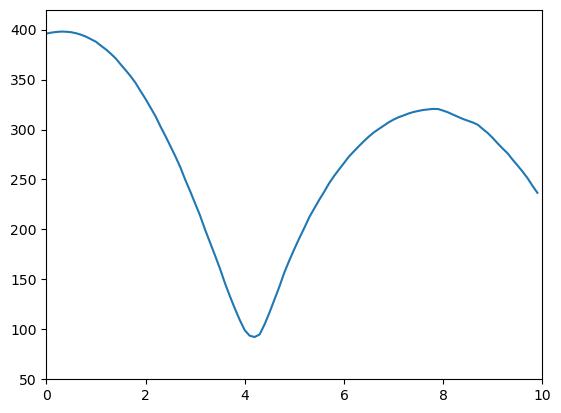

In [19]:
print(rm31[0],rm33[0],rmw[0])
print(rCOM_mw[0],rCOM_m31[0],rCOM_m33[0])
r_norm_m33 = np.linalg.norm(rCOM_m33, axis=1)
time = np.arange(0, 500, 5)/50
plt.plot(time, r_norm_m33)
plt.xlim(0, 10)
plt.ylim(50, 420)

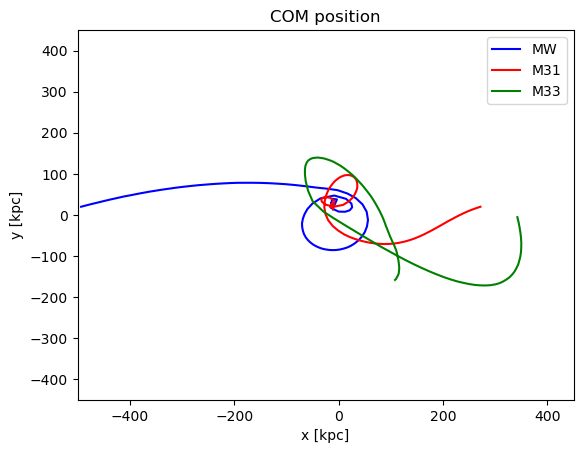

In [ ]:
plt.plot(rCOM_mw[:, 0], rCOM_mw[:, 1], 'b-', label='MW')
plt.plot(rCOM_m31[:, 0], rCOM_m31[:, 1], 'r-', label='M31')
plt.plot(rCOM_m33[:, 0], rCOM_m33[:, 1], 'g-', label='M33')
plt.legend()
plt.xlabel('x [kpc]')
plt.ylabel('y [kpc]')
plt.title('COM position')
plt.xlim(-500, 450)
plt.ylim(-450, 450)

plt.show()

/tmp/ipykernel_866930/317030802.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=10)
/tmp/ipykernel_866930/317030802.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=10)
/tmp/ipykernel_866930/317030802.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=10)
/tmp/ipykernel_866930/317030802.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=10)
/tmp/ipykernel_866930/317030802.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. afte

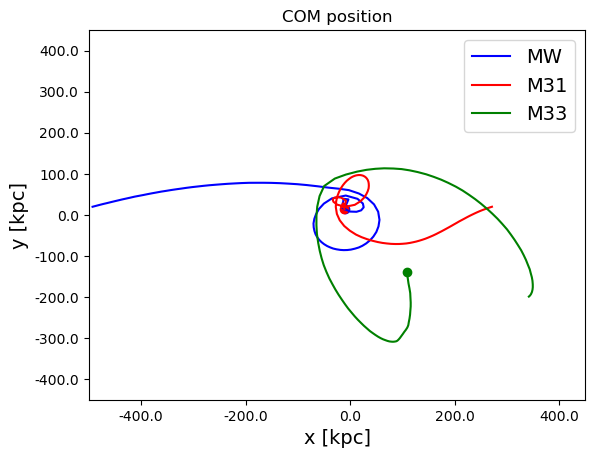

In [13]:
fig, ax = plt.subplots()
def update(frame):
    # 清除子图
    ax.clear()
    ax.plot(rCOM_mw[:, 0], rCOM_mw[:, 1], 'b-', label='MW')
    ax.plot(rCOM_m31[:, 0], rCOM_m31[:, 1], 'r-', label='M31')
    ax.plot(rCOM_m33[:, 0], rCOM_m33[:, 1], 'g-', label='M33')
    ax.scatter(rCOM_mw[frame, 0], rCOM_mw[frame, 1], c='b')
    ax.scatter(rCOM_m31[frame, 0], rCOM_m31[frame, 1], c='r')
    ax.scatter(rCOM_m33[frame, 0], rCOM_m33[frame, 1], c='g')
    ax.legend(fontsize=14)

    ax.set_xlabel('x [kpc]', fontsize=14)
    ax.set_ylabel('y [kpc]',fontsize=14)
    ax.set_title('COM position')
    ax.set_xlim(-500, 450)
    ax.set_ylim(-450, 450)
    ax.set_xticklabels(ax.get_xticks(), fontsize=10)
    ax.set_yticklabels(ax.get_yticks(), fontsize=10)
    
ani = FuncAnimation(fig, update, frames=len(rCOM_mw),  repeat=False)

# 保存动画为 GIF
ani.save('com_position_animation.gif', writer='pillow', fps=10)

# 在 Jupyter Notebook 中显示动画
plt.show()

(350000, 2)


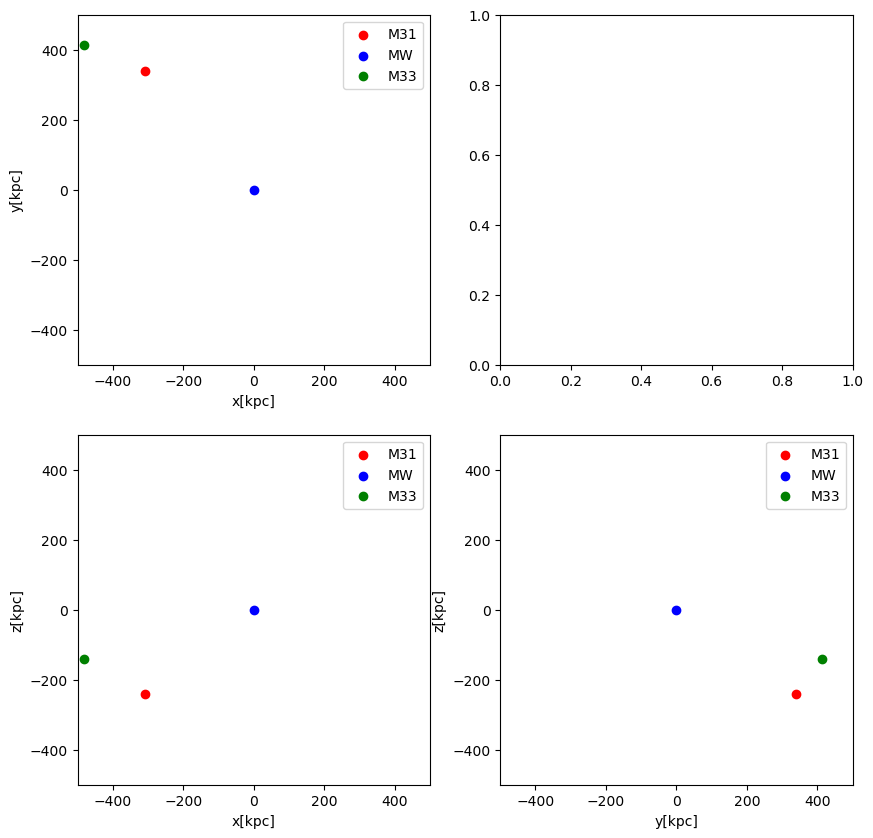

In [20]:

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# 绘制 x-y 图
axs[0, 0].scatter(r_mw_m31[0], r_mw_m31[1], c='r', label='M31')
axs[0, 0].scatter(0, 0, c='b', label='MW')
axs[0, 0].scatter(r_mw_m33[0], r_mw_m33[1], c='g', label='M33')
axs[0, 0].set_xlabel('x[kpc]')
axs[0, 0].set_ylabel('y[kpc]')
axs[0, 0].legend()
axs[0, 0].set_xlim(-500, 500)
axs[0, 0].set_ylim(-500, 500)

# 绘制 x-z 图
axs[1, 0].scatter(r_mw_m31[0], r_mw_m31[2], c='r', label='M31')
axs[1, 0].scatter(0, 0, c='b', label='MW')
axs[1, 0].scatter(r_mw_m33[0], r_mw_m33[2], c='g', label='M33')
axs[1, 0].set_xlabel('x[kpc]')
axs[1, 0].set_ylabel('z[kpc]')
axs[1, 0].legend()
axs[1, 0].set_xlim(-500, 500)
axs[1, 0].set_ylim(-500, 500)

# 绘制 y-z 图
axs[1, 1].scatter(r_mw_m31[1], r_mw_m31[2], c='r', label='M31')
axs[1, 1].scatter(0, 0, c='b', label='MW')
axs[1, 1].scatter(r_mw_m33[1], r_mw_m33[2], c='g', label='M33')
axs[1, 1].set_xlabel('y[kpc]')
axs[1, 1].set_ylabel('z[kpc]')
axs[1, 1].legend()
axs[1, 1].set_xlim(-500, 500)
axs[1, 1].set_ylim(-500, 500)

# 绘制 r 随时间变化的图
'''axs[0, 1].plot(time_values[:frame+1], r_values[:frame+1], 'g-')
axs[0, 1].set_xlabel('Time')
axs[0, 1].set_ylabel('r')
axs[0, 1].set_title('r vs Time')
axs[0, 1].set_xlim(0, 10)
axs[0, 1].set_ylim(0, 800)'''

print(posMW[:, [0, 1]].shape)

Returning DM    Positions
Returning DM    Particle IDs
Returning DISK  Positions
Returning BULGE Positions
Returning DISK  Particle IDs
Returning BULGE Particle IDs
Returning BULGE Velocities
[0.00071697 0.00290847 0.00360545]
Returning DM    Positions
Returning DM    Positions
Returning DM    Positions
Returning DM    Particle IDs
Returning DM    Particle IDs
Returning DM    Positions
Returning DM    Particle IDs
Returning DM    Particle IDs
Returning DM    Positions
Returning DISK  Positions
Returning BULGE Positions
Returning DISK  Positions
Returning DM    Particle IDs
Returning DISK  Particle IDs
Returning BULGE Positions
Returning DISK  PositionsReturning BULGE Particle IDs

Returning DISK  Positions
Returning DISK  Particle IDs
Returning BULGE Positions
Returning BULGE Positions
Returning BULGE Particle IDs
Returning DISK  Particle IDs
Returning BULGE Velocities
Returning DISK  Particle IDsReturning BULGE Particle IDs

Returning BULGE Particle IDs
Returning BULGE Velocities
Retu

(0.0, 800.0)

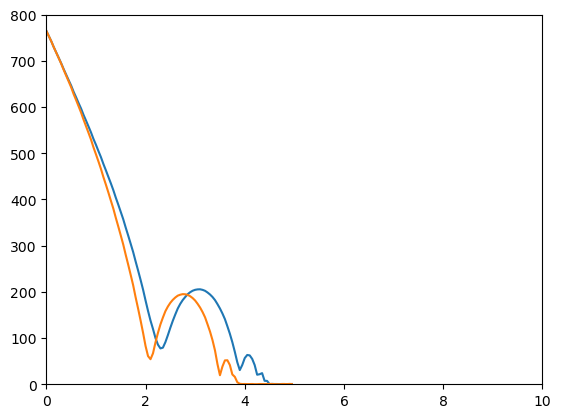

In [11]:
r_nom31=np.load('r_values.npz.npy')
frames = np.arange(0, 500, 5)
# 并行读取数据
results = Parallel(n_jobs=20)(delayed(read)(runpath, i) for i in frames)
r_values = np.array([np.linalg.norm(r_mw_m31) for posMW, posM31,posM33,r_mw_m31,r_mw_m33,r_m31_m33 in results])
time_values = frames/100
np.save('r_values_m33.npz', r_values)
plt.plot(time_values, r_values)
plt.plot(time_values,r_nom31)
plt.xlim(0,10)
plt.ylim(0,800)


In [4]:
10**(24.61/5+1)

835603.0182312474

Returning DM    Positions
Returning DM    Particle IDs
Returning DISK  Positions
Returning BULGE Positions
Returning DISK  Particle IDs
Returning BULGE Particle IDs
Returning BULGE Velocities
[-0.00039104  0.00064812  0.00128763]


/tmp/ipykernel_3802381/1421523172.py:59: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  HTML(ani.to_jshtml())


/home/guozx/anaconda3/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/guozx/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


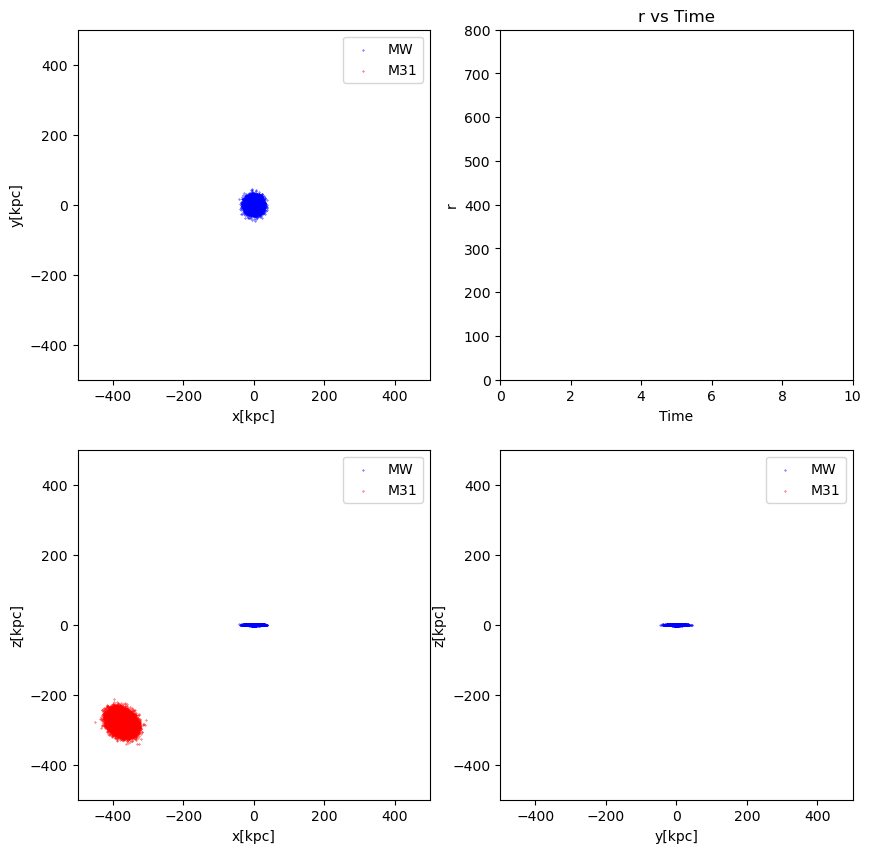

In [ ]:
runpath = '/home/guozx/M31/Output/merge/'
frames = np.arange(0, 10, 10)

# 并行读取数据
results = Parallel(n_jobs=2)(delayed(read)(runpath, i) for i in frames)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))

r_values = [np.linalg.norm(result[4]) for result in results]
time_values = list(frames/50)
def update(frame):
    posdm_MW,posdm_M31,posMW, posM31,r = results[frame]
    
    # 清除子图
    for ax in axs.flat:
        ax.clear()
    
    # 绘制 x-y 图
    axs[0, 0].scatter(posMW[:,0], posMW[:,1], s=0.1, c='b', label='MW')
    axs[0, 0].scatter(posM31[:,0], posM31[:,1], s=0.1, c='r', label='M31')
    axs[0, 0].set_xlabel('x[kpc]')
    axs[0, 0].set_ylabel('y[kpc]')
    axs[0, 0].legend()
    axs[0, 0].set_xlim(-500, 500)
    axs[0, 0].set_ylim(-500, 500)
    
    # 绘制 x-z 图
    axs[1, 0].scatter(posMW[:,0], posMW[:,2], s=0.1, c='b', label='MW')
    axs[1, 0].scatter(posM31[:,0], posM31[:,2], s=0.1, c='r', label='M31')
    axs[1, 0].set_xlabel('x[kpc]')
    axs[1, 0].set_ylabel('z[kpc]')
    axs[1, 0].legend()
    axs[1, 0].set_xlim(-500, 500)
    axs[1, 0].set_ylim(-500, 500)
    
    # 绘制 y-z 图
    axs[1, 1].scatter(posMW[:,1], posMW[:,2], s=0.1, c='b', label='MW')
    axs[1, 1].scatter(posM31[:,1], posM31[:,2], s=0.1, c='r', label='M31')
    axs[1, 1].set_xlabel('y[kpc]')
    axs[1, 1].set_ylabel('z[kpc]')
    axs[1, 1].legend()
    axs[1, 1].set_xlim(-500, 500)
    axs[1, 1].set_ylim(-500, 500)
    
    # 绘制 r 随时间变化的图
    axs[0, 1].plot(time_values[:frame+1], r_values[:frame+1], 'g-')
    axs[0, 1].set_xlabel('Time')
    axs[0, 1].set_ylabel('r')
    axs[0, 1].set_title('r vs Time')
    axs[0, 1].set_xlim(0, 10)
    axs[0, 1].set_ylim(0, 800)
    
ani = FuncAnimation(fig, update, frames=len(frames), repeat=False)

# 保存动画
#ani.save('m31_vs_mw_animation.gif', writer=PillowWriter(fps=5))

# 在 Jupyter Notebook 中显示动画
HTML(ani.to_jshtml())

In [1]:
10**(24.67/5+1)

859013.521505396

In [2]:
(-384.2947991929431+515.3384350)**2+ ( 620.6460-531.2805467)**2+(285.798-445.348)**2

50614.82122904705

In [ ]:
-384.2947991929431 kpc 620.6460214974461 kpc -285.79823559569974

In [6]:
r_m31 = np.array([-375.1316149740847,605.5277209737903,-278.83597703631733]) 
v_m31 = np.array([37.53564320437491,-114.3816276001235,15.117831344570334])#dr3
r_m33 = np.array([-515.3384350233484, 531.2805467278157, -445.3480827169192]) 
v_m33 = np.array([-83.85912546420454, -54.26271655187622,107.4625381352587])

In [10]:
v_cm= 0.6*v_m31
v = v_m33-v_cm
print(v)
v= np.dot(v, A)
print(v)

[-106.38051139   14.36626001   98.39183933]
[  27.67616736   24.37978645 -140.86806753]


In [20]:
print(r_m33-r_m31)
print(v_m33-v_m31)

[-140.20682005  -74.24717425 -166.51210568]
[-121.39476867   60.11891105   92.34470679]
